### Импорт библиотек

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=252d3ab972e0cf429f326df98fbb7348fcec6519c5efbf3f062af902252e3459
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import os.path
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import re
import pymorphy2
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from string import punctuation
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [4]:
# set seeds
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Импорт данных

In [5]:
csv_data = pd.read_csv('Data_ASR_2.csv')

In [6]:
def calc_sentiment_label(row):
  if row['sentiment'] > 0:
    return 1
  elif row['sentiment'] < 0:
    return 2 # чтобы не было -1 в лейблах
  else:
    return 0

csv_data['sentiment_label'] = csv_data.apply(calc_sentiment_label, axis=1)

In [7]:
csv_data.sample(3)

,video,start_time,end_time,sentiment,happy,sad,anger,surprise,disgust,fear,text,ASR,sentiment_label
16519,ak7N0BqMluI,59.057,64.7700,-0.333333,0.000000,1.0,0.0,0.0,0.0,0.0,"If you fail to meet the terms of the contract,...",the foul to meet the terms of the contract yo...,2
6366,30763,73.426,77.8355,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,At first she's just so great and then she doe...,at first she just so great and ancient at eve...,1
2602,216007,0.101,0.9700,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,Hi,hi,1


In [8]:
csv_data.shape

(23259, 13)

In [9]:
!unzip '/content/drive/MyDrive/masters/ML/Audio.zip'

Archive:  /content/drive/MyDrive/masters/ML/Audio.zip
   creating: Audio/
   creating: Audio/WAV_16000/
 extracting: Audio/WAV_16000/--qXJuDtHPw.wav  
 extracting: Audio/WAV_16000/-3g5yACwYnA.pkf  
 extracting: Audio/WAV_16000/-3g5yACwYnA.wav  
 extracting: Audio/WAV_16000/-3nNcZdcdvU.wav  
 extracting: Audio/WAV_16000/-571d8cVauQ.wav  
 extracting: Audio/WAV_16000/-6rXp3zJ3kc.wav  
 extracting: Audio/WAV_16000/-9YyBTjo1zo.pkf  
 extracting: Audio/WAV_16000/-9YyBTjo1zo.wav  
 extracting: Audio/WAV_16000/-9y-fZ3swSY.wav  
 extracting: Audio/WAV_16000/-AUZQgSxyPQ.wav  
 extracting: Audio/WAV_16000/-Alixo7euuU.wav  
 extracting: Audio/WAV_16000/-Eqdz5y4pEY.wav  
 extracting: Audio/WAV_16000/-HeZS2-Prhc.wav  
 extracting: Audio/WAV_16000/-HvKLjmsO5U.wav  
 extracting: Audio/WAV_16000/-HwX2H8Z4hY.wav  
 extracting: Audio/WAV_16000/-IUUR2yyNbw.wav  
 extracting: Audio/WAV_16000/-I_e4mIh0yE.wav  
 extracting: Audio/WAV_16000/-IqSFQePnpU.wav  
 extracting: Audio/WAV_16000/-KCahx2qBOI.wav  
 ex

In [10]:
filenames = csv_data[['video', 'start_time', 'end_time']]
filenames.head(3)

,video,start_time,end_time
0,--qXJuDtHPw,23.1990,30.325
1,-3g5yACwYnA,82.7645,100.555
2,-3g5yACwYnA,119.9190,125.299


### Препроцессинг текстовых данных

In [11]:
text_data = csv_data['text'].tolist()
text_data[0]

'I see that a writer is somebody who has an incredible command of mechanics of the English language.'

In [12]:
def preprocess(string):
  result = word_tokenize(string)

  punctiations = list(punctuation)
  result = [i for i in result if (i not in punctiations)]

  result =  [i.lower() for i in result]

  stop_words = nltk.corpus.stopwords.words('english')
  result = [i for i in result if ( i not in stop_words )]

  wnl = WordNetLemmatizer()
  result = [wnl.lemmatize(word, pos="v") for word in result]

  return ' '.join(result)

In [13]:
preprocessed_text_data = [preprocess(string) for string in text_data]
preprocessed_text_data[0]

'see writer somebody incredible command mechanics english language'

### Извлечение признаков

In [14]:
vectorizer = CountVectorizer(max_features=10000, min_df=1)
bow_X = vectorizer.fit_transform(preprocessed_text_data).toarray()

In [15]:
len(bow_X)

23259

In [16]:
def calculate_mfcc(row, n_mfcc=20, hop_length=512, maxlen=300):
    audio_path = row['video']
    audio_path = '/content/Audio/WAV_16000/' + audio_path + '.wav'

    start_time = row['start_time']
    end_time = row['end_time']
    duration = end_time - start_time
    audio, sr = librosa.load(audio_path, offset=start_time, duration=duration, sr=None)

    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)

    # приводим к одном длине
    if maxlen and mfcc_features.shape[1] > maxlen:
      mfcc_features = mfcc_features[:, :maxlen]
    elif maxlen and mfcc_features.shape[1] < maxlen:
      mfcc_features = np.pad(mfcc_features, ((0, 0), (0, maxlen - mfcc_features.shape[1]) ))
    return mfcc_features

In [17]:
mfcc_X = []
for index, row in filenames.iterrows():
  mfcc_X.append(calculate_mfcc(row))

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(


In [18]:
len(mfcc_X)

23259

### Подготовка к обучению

In [19]:
y = csv_data['sentiment_label'].tolist()

In [36]:
vocab_size = len(vectorizer.vocabulary_)
mfcc_shape = mfcc_X[0].shape
num_classes = 3
num_epochs = 10

### Нейронная сеть

In [21]:
text_train, text_test, audio_train, audio_test, y_train, y_test = train_test_split(
    bow_X, mfcc_X, y, test_size=0.2, random_state=42)

text_train = torch.tensor(text_train, dtype=torch.float32).cuda()
text_test = torch.tensor(text_test, dtype=torch.float32).cuda()
audio_train = torch.tensor(audio_train, dtype=torch.float32).cuda()
audio_test = torch.tensor(audio_test, dtype=torch.float32).cuda()
y_train = torch.tensor(y_train, dtype=torch.long).cuda()
y_test = torch.tensor(y_test, dtype=torch.long).cuda()

train_dataset = TensorDataset(text_train, audio_train, y_train)
test_dataset = TensorDataset(text_test, audio_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

<ipython-input-21-e2d850290aec>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  audio_train = torch.tensor(audio_train, dtype=torch.float32).cuda()


In [32]:
class MultimodalSentimentAnalysis(nn.Module):
    def __init__(self):
        super(MultimodalSentimentAnalysis, self).__init__()
        # Текстовая часть (BoW)
        self.text_fc1 = nn.Linear(vocab_size, 256)
        self.text_fc2 = nn.Linear(256, 128)

        # Аудио часть (MFCC)
        self.audio_conv1 = nn.Conv1d(in_channels=mfcc_shape[0], out_channels=32, kernel_size=3)
        self.audio_maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.audio_conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.audio_maxpool2 = nn.MaxPool1d(kernel_size=2)
        self.audio_flatten = nn.Flatten()

        # Полносвязные слои для объединённого вектора
        self.fc1 = nn.Linear(96 + (mfcc_shape[1] - 4) * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, text, audio):
        # Текстовая часть
        text_out = self.text_fc1(text)
        text_out = torch.relu(text_out)
        text_out = self.text_fc2(text_out)
        text_out = torch.relu(text_out)

        # Аудио часть
        audio_out = self.audio_conv1(audio)
        audio_out = torch.relu(audio_out)
        audio_out = self.audio_maxpool1(audio_out)
        audio_out = self.audio_conv2(audio_out)
        audio_out = torch.relu(audio_out)
        audio_out = self.audio_maxpool2(audio_out)
        audio_out = self.audio_flatten(audio_out)

        # Объединение и классификация
        combined = torch.cat((text_out, audio_out), dim=1)

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

    def train_model(self, train_loader, val_loader, num_epochs, learning_rate=0.001):
      optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=0.001)
      criterion = nn.CrossEntropyLoss()

      train_losses = []
      val_losses = []
      train_f1s = []
      val_f1s = []
      train_labels_all = []
      train_outputs_all = []
      test_labels_all = []
      test_outputs_all = []
      running_train_loss = 0.0

      for epoch in range(num_epochs):
        for batch_text, batch_audio, batch_labels in train_loader:
          optimizer.zero_grad()
          outputs = self(batch_text, batch_audio)
          loss = criterion(outputs, batch_labels)
          loss.backward()
          optimizer.step()

          running_train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          train_labels_all.extend(batch_labels.cpu().numpy())
          train_outputs_all.extend(predicted.cpu().numpy())

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_f1s.append(f1_score(train_labels_all, train_outputs_all, average='weighted'))

        self.eval()
        running_val_loss = 0.0

        with torch.no_grad():
          for batch_text, batch_audio, batch_labels in val_loader:
            outputs = self(batch_text, batch_audio)
            loss = criterion(outputs, batch_labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            test_labels_all.extend(batch_labels.tolist())
            test_outputs_all.extend(predicted.tolist())

          val_loss = running_val_loss / len(val_loader)
          val_losses.append(val_loss)
          val_f1s.append(f1_score(test_labels_all, test_outputs_all, average='weighted'))

          print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

      return train_losses, val_losses, train_f1s, val_f1s

### Обучение

In [37]:
model = MultimodalSentimentAnalysis()
model.cuda()

MultimodalSentimentAnalysis(
  (text_fc1): Linear(in_features=10000, out_features=256, bias=True)
  (text_fc2): Linear(in_features=256, out_features=128, bias=True)
  (audio_conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,))
  (audio_maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (audio_conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (audio_maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (audio_flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2464, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [38]:
train_losses, val_losses, train_f1s, val_f1s = model.train_model(train_loader, test_loader, num_epochs)

Epoch [1/10], Train Loss: 1.2211, Val Loss: 0.9033
Epoch [2/10], Train Loss: 2.0783, Val Loss: 0.8814
Epoch [3/10], Train Loss: 2.8834, Val Loss: 0.8756
Epoch [4/10], Train Loss: 3.6320, Val Loss: 0.8958
Epoch [5/10], Train Loss: 4.3108, Val Loss: 0.9185
Epoch [6/10], Train Loss: 4.9004, Val Loss: 0.9627
Epoch [7/10], Train Loss: 5.3748, Val Loss: 1.0638
Epoch [8/10], Train Loss: 5.7196, Val Loss: 1.2424
Epoch [9/10], Train Loss: 5.9566, Val Loss: 1.4965
Epoch [10/10], Train Loss: 6.1217, Val Loss: 1.6383


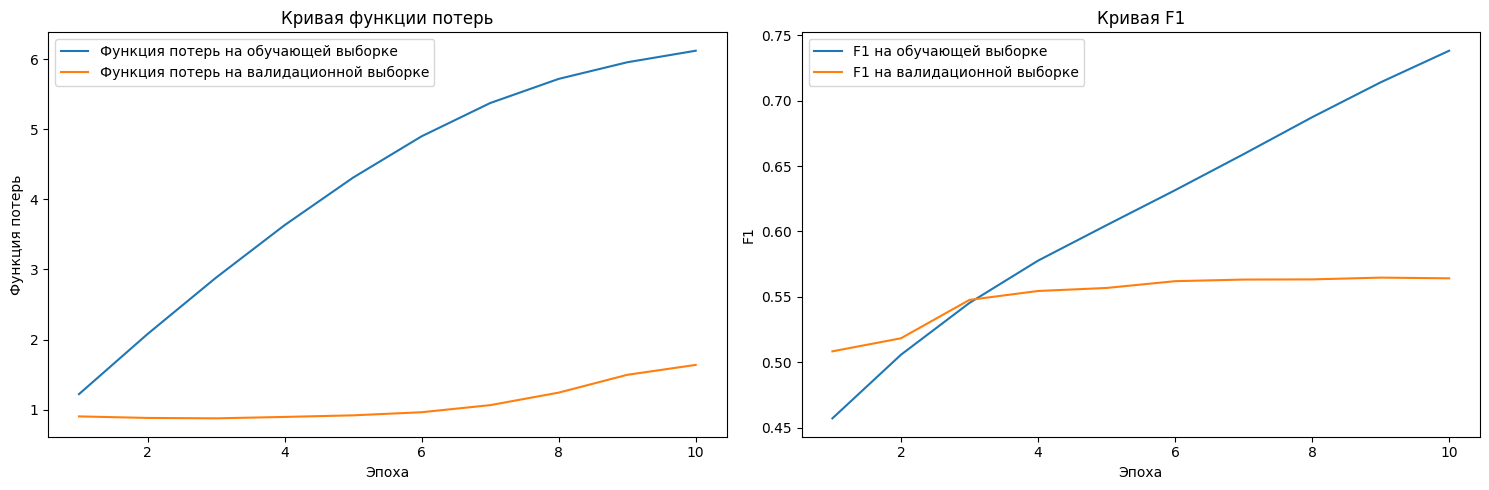

In [39]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Функция потерь на обучающей выборке')
plt.plot(epochs, val_losses, label='Функция потерь на валидационной выборке')
plt.title('Кривая функции потерь')
plt.xlabel('Эпоха')
plt.ylabel('Функция потерь')
plt.legend(loc = "upper left")
plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label='F1 на обучающей выборке')
plt.plot(epochs, val_f1s, label='F1 на валидационной выборке')
plt.title('Кривая F1')
plt.xlabel('Эпоха')
plt.ylabel('F1')
plt.legend(loc = "upper left")

plt.tight_layout()
plt.show()